Projeto Final de Spark

Campanha Nacional de Vacinação contra Covid-19

Nível Básico:
Visualizações à partir dos dados: https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/04bd3419b22b9cc5c6efac2c6528100d_HIST_PAINEL_COVIDBR_06jul2021.rar

1. Enviar os dados para o hdfs.

In [ ]:
!hdfs dfs -put /input/HIST_PAINEL_COVIDBR_06jul2021 /user/jes/data

In [1]:
!hdfs dfs -ls /user/jes/data/HIST_PAINEL_COVIDBR_06jul2021

Found 4 items
-rw-r--r--   3 root supergroup   62492959 2021-07-13 00:36 /user/jes/data/HIST_PAINEL_COVIDBR_06jul2021/HIST_PAINEL_COVIDBR_2020_Parte1_06jul2021.csv
-rw-r--r--   3 root supergroup   76520681 2021-07-13 00:36 /user/jes/data/HIST_PAINEL_COVIDBR_06jul2021/HIST_PAINEL_COVIDBR_2020_Parte2_06jul2021.csv
-rw-r--r--   3 root supergroup   91120916 2021-07-13 00:36 /user/jes/data/HIST_PAINEL_COVIDBR_06jul2021/HIST_PAINEL_COVIDBR_2021_Parte1_06jul2021.csv
-rw-r--r--   3 root supergroup    3046774 2021-07-13 00:36 /user/jes/data/HIST_PAINEL_COVIDBR_06jul2021/HIST_PAINEL_COVIDBR_2021_Parte2_06jul2021.csv


2. Otimizar todos os dados do hdfs para uma tabela Hive particionada por município.

In [1]:
import pyspark.sql.functions as F
from pyspark.sql.types import *

In [4]:
painel_covidDF = spark.read.option("inferSchema","true") \
                         .option("header","true") \
                         .options(delimiter=';') \
                         .csv("/user/jes/data/HIST_PAINEL_COVIDBR_06jul2021/HIST_PAINEL_COVIDBR_202*.csv")

In [7]:
painel_covidDF.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- coduf: integer (nullable = true)
 |-- codmun: integer (nullable = true)
 |-- codRegiaoSaude: integer (nullable = true)
 |-- nomeRegiaoSaude: string (nullable = true)
 |-- data: timestamp (nullable = true)
 |-- semanaEpi: integer (nullable = true)
 |-- populacaoTCU2019: integer (nullable = true)
 |-- casosAcumulado: decimal(10,0) (nullable = true)
 |-- casosNovos: integer (nullable = true)
 |-- obitosAcumulado: integer (nullable = true)
 |-- obitosNovos: integer (nullable = true)
 |-- Recuperadosnovos: integer (nullable = true)
 |-- emAcompanhamentoNovos: integer (nullable = true)
 |-- interior/metropolitana: integer (nullable = true)



In [6]:
painel_covid_hive_partitionDF = painel_covidDF.write.partitionBy("municipio").saveAsTable("painel_covid")

3. Criar as 3 vizualizações pelo Spark com os dados enviados para o HDFS:
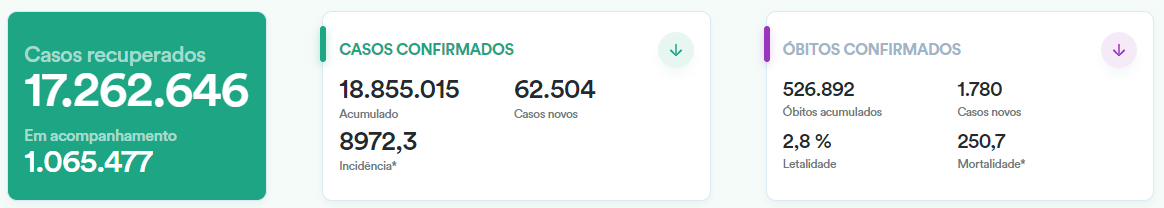

In [2]:
painel_covid_hdfsDF = spark.read.table("painel_covid")

In [10]:
painel_covid_hdfsDF.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- coduf: integer (nullable = true)
 |-- codmun: integer (nullable = true)
 |-- codRegiaoSaude: integer (nullable = true)
 |-- nomeRegiaoSaude: string (nullable = true)
 |-- data: timestamp (nullable = true)
 |-- semanaEpi: integer (nullable = true)
 |-- populacaoTCU2019: integer (nullable = true)
 |-- casosAcumulado: decimal(10,0) (nullable = true)
 |-- casosNovos: integer (nullable = true)
 |-- obitosAcumulado: integer (nullable = true)
 |-- obitosNovos: integer (nullable = true)
 |-- Recuperadosnovos: integer (nullable = true)
 |-- emAcompanhamentoNovos: integer (nullable = true)
 |-- interior/metropolitana: integer (nullable = true)
 |-- municipio: string (nullable = true)



4. Salvar a primeira visualização como tabela Hive

In [27]:
covid_recup_acompDF = painel_covid_hdfsDF.select(F.col("Recuperadosnovos").alias("Casos_recuperados"), \
                                                 F.col("emAcompanhamentoNovos").alias("Em_acompanhamento")) \
                                         .where(F.col("regiao") == "Brasil") \
                                         .sort(F.desc("data")) \
                                         .limit(1)

In [25]:
covid_recup_acompDF.show(truncate=False)

+-----------------+-----------------+
|Casos recuperados|Em acompanhamento|
+-----------------+-----------------+
|17262646         |1065477          |
+-----------------+-----------------+



In [28]:
covid_recup_acompDF.write.saveAsTable("covid_recup_acomp")

5. Salvar a segunda visualização com formato parquet e compressão snappy

In [42]:
covid_casos_confirmDF = painel_covid_hdfsDF.select(F.col("casosAcumulado"), \
                                                   F.col("casosNovos"), \
                                                   F.format_number(((F.col("casosAcumulado") * F.lit(100000)) / F.col("populacaoTCU2019")),1).alias("Incidencia")) \
                                         .where(F.col("regiao") == "Brasil") \
                                         .sort(F.desc("data")) \
                                         .limit(1)

In [43]:
covid_casos_confirmDF.show(truncate=False)

+--------------+----------+----------+
|casosAcumulado|casosNovos|Incidencia|
+--------------+----------+----------+
|18855015      |62504     |8,972.3   |
+--------------+----------+----------+



In [44]:
covid_casos_confirmDF.write.save("/user/jes/painel_covid_parquet")

In [45]:
!hdfs dfs -ls /user/jes/painel_covid_parquet

Found 2 items
-rw-r--r--   2 root supergroup          0 2021-07-13 03:42 /user/jes/painel_covid_parquet/_SUCCESS
-rw-r--r--   2 root supergroup        955 2021-07-13 03:42 /user/jes/painel_covid_parquet/part-00000-80d57540-78d4-4038-89cd-d69259aa47dc-c000.snappy.parquet


6. Salvar a terceira visualização em um tópico no Kafka

In [3]:
covid_obito = painel_covid_hdfsDF.select(F.col("obitosAcumulado").alias("Obitos_acumulados"), \
                                         F.col("obitosNovos").alias("Obitos_novos"), \
                                         F.format_number(((F.col("obitosAcumulado") * F.lit(100)) / F.col("casosAcumulado")),1).alias("Letalidade"), \
                                         F.format_number(((F.col("obitosAcumulado") * F.lit(1000)) / F.col("populacaoTCU2019")),1).alias("Mortalidade")) \
                                         .where(F.col("regiao") == "Brasil") \
                                         .sort(F.desc("data")) \
                                         .limit(1)

In [40]:
covid_obito.show(truncate=False)

+-----------------+------------+----------+-----------+
|Obitos_acumulados|Obitos_novos|Letalidade|Mortalidade|
+-----------------+------------+----------+-----------+
|526892           |1780        |2.8       |2.5        |
+-----------------+------------+----------+-----------+



In [37]:
covid_obito.select(F.col("Obitos_acumulados").cast("string").alias("value")).write \
           .format("kafka") \
           .option("kafka.bootstrap.servers", "kafka:9092") \
           .option("topic", "topic-covid") \
           .save()

7. Criar a visualização pelo Spark com os dados enviados para o HDFS:
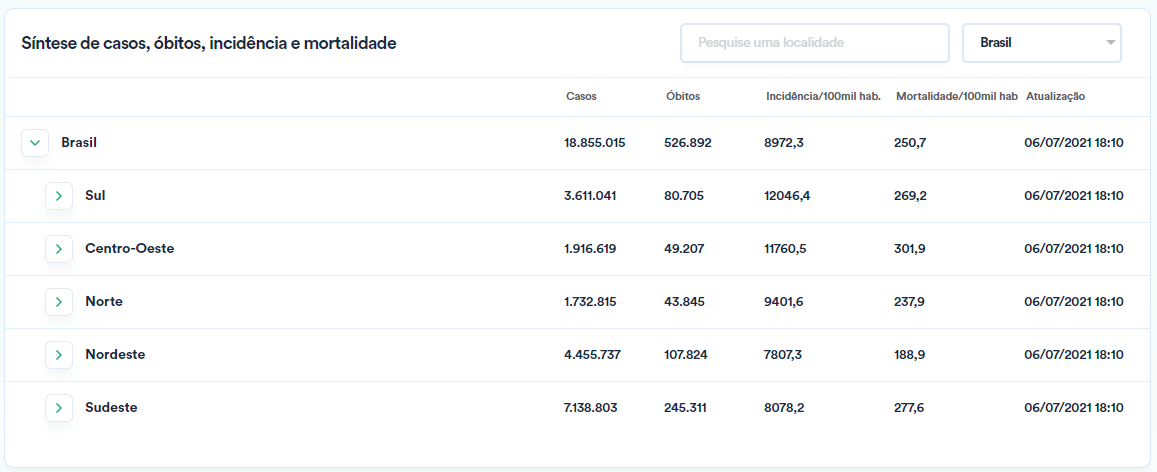

In [26]:
covid_estadual = painel_covid_hdfsDF.select(F.col("estado"),F.struct(F.col("regiao"), \
                                            F.col("municipio"),F.col("data"), \
                                            F.col("populacaoTCU2019"),F.col("casosAcumulado"), \
                                            F.col("obitosAcumulado")).alias("vs")) \
                                    .where(F.col("vs.municipio").isNull()) \
                                    .groupBy(F.col("estado")) \
                                    .agg(F.max(F.col("vs")).alias("strct"))

In [85]:
covid_estadual.printSchema()

root
 |-- estado: string (nullable = true)
 |-- strct: struct (nullable = true)
 |    |-- regiao: string (nullable = true)
 |    |-- municipio: string (nullable = true)
 |    |-- data: timestamp (nullable = true)
 |    |-- populacaoTCU2019: integer (nullable = true)
 |    |-- casosAcumulado: decimal(10,0) (nullable = true)
 |    |-- obitosAcumulado: integer (nullable = true)



In [84]:
covid_estadual.show(truncate=False)

+------+------------------------------------------------------------+
|estado|strct                                                       |
+------+------------------------------------------------------------+
|SC    |[Sul,, 2021-07-06 00:00:00, 7164788, 1066484, 17146]        |
|RO    |[Norte,, 2021-07-06 00:00:00, 1777225, 251977, 6226]        |
|PI    |[Nordeste,, 2021-07-06 00:00:00, 3273227, 299084, 6662]     |
|AM    |[Norte,, 2021-07-06 00:00:00, 4144597, 405066, 13349]       |
|RR    |[Norte,, 2021-07-06 00:00:00, 605761, 113758, 1763]         |
|GO    |[Centro-Oeste,, 2021-07-06 00:00:00, 7018354, 686433, 19485]|
|null  |[Brasil,, 2021-07-06 00:00:00, 210147125, 18855015, 526892] |
|TO    |[Norte,, 2021-07-06 00:00:00, 1572866, 200243, 3266]        |
|MT    |[Centro-Oeste,, 2021-07-06 00:00:00, 3484466, 456155, 12000]|
|SP    |[Sudeste,, 2021-07-06 00:00:00, 45919049, 3809222, 130389]  |
|ES    |[Sudeste,, 2021-07-06 00:00:00, 4018650, 523115, 11582]     |
|PB    |[Nordeste,, 

In [32]:
covid_regional = covid_estadual.groupBy(F.col("strct.regiao").alias("regiao")).agg( \
                                        F.sum(F.col("strct.casosAcumulado")).alias("casos"), \
                                        F.sum(F.col("strct.obitosAcumulado")).alias("obitos"), \
                                        F.sum(F.col("strct.populacaoTCU2019")).alias("populacao")) \
                               .sort(F.col("regiao"))

In [33]:
covid_regional.show()

+------------+--------+------+---------+
|      regiao|   casos|obitos|populacao|
+------------+--------+------+---------+
|      Brasil|18855015|526892|210147125|
|Centro-Oeste| 1916619| 49207| 16297074|
|    Nordeste| 4455737|107824| 57071654|
|       Norte| 1732815| 43845| 18430980|
|     Sudeste| 7138803|245311| 88371433|
|         Sul| 3611041| 80705| 29975984|
+------------+--------+------+---------+



In [37]:
covid_regional_visualizacao = covid_regional.select(F.col("regiao"), \
                                                    F.col("casos"), \
                                                    F.col("obitos"), \
                                                    F.translate(F.format_number(((F.col("casos") / F.col("populacao")) * F.lit(100000)),1),",.",".,").alias("Incidencia"), \
                                                    F.translate(F.format_number(((F.col("obitos") / F.col("populacao")) * F.lit(100000)),1),",.",".,").alias("Mortalidade"))

In [38]:
covid_regional_visualizacao.show()

+------------+--------+------+----------+-----------+
|      regiao|   casos|obitos|Incidencia|Mortalidade|
+------------+--------+------+----------+-----------+
|      Brasil|18855015|526892|   8.972,3|      250,7|
|Centro-Oeste| 1916619| 49207|  11.760,5|      301,9|
|    Nordeste| 4455737|107824|   7.807,3|      188,9|
|       Norte| 1732815| 43845|   9.401,6|      237,9|
|     Sudeste| 7138803|245311|   8.078,2|      277,6|
|         Sul| 3611041| 80705|  12.046,4|      269,2|
+------------+--------+------+----------+-----------+



8. Salvar a visualização do exercício 6 em um tópico no Elastic

In [5]:
esURL = "https://<my>.elastic-cloud.com"

In [8]:
covid_obito.write \
           .format("org.elasticsearch.spark.sql") \
           .option("es.nodes.wan.only","true") \
           .option("es.port","<porta>") \
           .option("es.net.ssl","true") \
           .option("es.nodes", esURL) \
           .option("es.net.http.auth.user", "<usuario>") \
           .option("es.net.http.auth.pass", "<senha>") \
           .option("es.resource", "covidbr/_doc") \
           .save()

9. Criar um dashboard no Elastic para visualização dos novos dados enviados

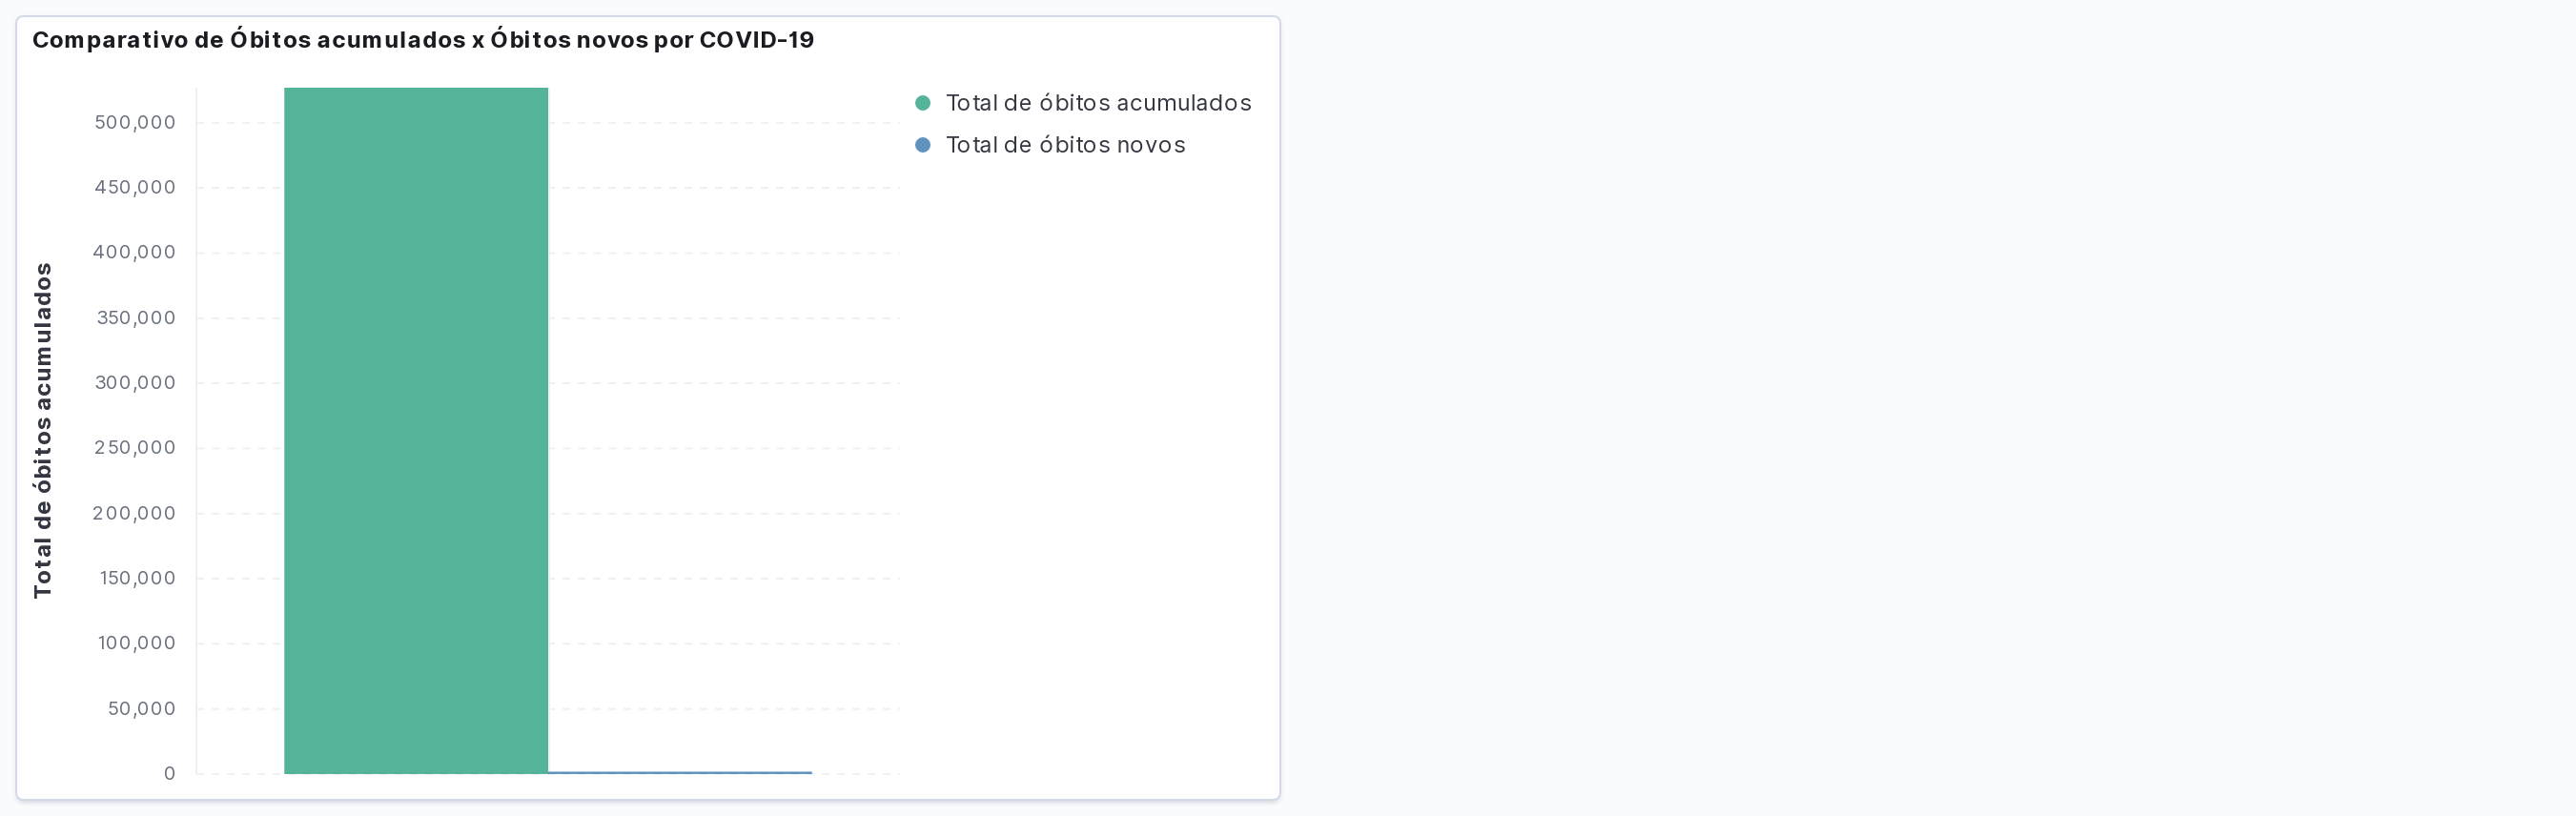

Observações:
Para as questões 8 e 9 foi utilizada uma instância gratuita do Elastic Cloud e a biblioteca elasticsearch-hadoop-7.13.3.jar